In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.pylab as plb 
import seaborn as sns
import warnings 
warnings.filterwarnings("ignore") # Ignore warnings
import time 
import datetime as dt 
from sklearn.linear_model import LinearRegression 
from sklearn import linear_model
from PIL import Image 
from matplotlib.pyplot import imshow 
import cv2 
import imageio 
import datetime
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold

In [2]:
df=pd.read_csv(r"C:\Users\ubtn\Desktop\IE-05\Data Mining\HW3\Data\GerçekZamanlı1.csv",encoding='cp1252',parse_dates=[['Tarih', 'Saat']],infer_datetime_format =True,dayfirst =True,thousands='.', decimal=',')
df.rename(columns= {"Tarih_Saat":"Time","Tüketim Miktarý (MWh)":"consumwh"}, inplace= True )
df["consumwh"]=df['consumwh'].astype(float)                  #Convert the datatype of consumption to float
df.head(5)

,Time,consumwh
0,2016-01-01 00:00:00,26277.24
1,2016-01-01 01:00:00,24991.82
2,2016-01-01 02:00:00,23532.61
3,2016-01-01 03:00:00,22464.78
4,2016-01-01 04:00:00,22002.91


Create the feature of 168 hours and 48 hours ago consumption values

In [3]:
df["Lag_48"] = df["consumwh"].shift(48)
df["Lag_168"] = df["consumwh"].shift(168)
#Since we shifted data by 48 & 168 units in lag columns, first 48&168 hours of the data will be NA.
df.head()

,Time,consumwh,Lag_48,Lag_168
0,2016-01-01 00:00:00,26277.24,NaN,NaN
1,2016-01-01 01:00:00,24991.82,NaN,NaN
2,2016-01-01 02:00:00,23532.61,NaN,NaN
3,2016-01-01 03:00:00,22464.78,NaN,NaN
4,2016-01-01 04:00:00,22002.91,NaN,NaN


In [4]:
df.dropna(how="any",inplace = True) #We can drop first 168 rows since we will be using 48 hours and 168 hours ago features
df.head()

,Time,consumwh,Lag_48,Lag_168
168,2016-01-08 00:00:00,28602.02,29189.27,26277.24
169,2016-01-08 01:00:00,27112.37,27614.02,24991.82
170,2016-01-08 02:00:00,25975.34,26578.97,23532.61
171,2016-01-08 03:00:00,25315.55,25719.19,22464.78
172,2016-01-08 04:00:00,25128.15,25864.63,22002.91


In [5]:
df.reset_index(inplace=True, drop=True)
df_lasso=df.copy() #Required for part d
df.head()

,Time,consumwh,Lag_48,Lag_168
0,2016-01-08 00:00:00,28602.02,29189.27,26277.24
1,2016-01-08 01:00:00,27112.37,27614.02,24991.82
2,2016-01-08 02:00:00,25975.34,26578.97,23532.61
3,2016-01-08 03:00:00,25315.55,25719.19,22464.78
4,2016-01-08 04:00:00,25128.15,25864.63,22002.91


In [6]:
#for MAPE calculations, define a function
def mean_absolute_percentage_error(y,yi):
    y,yi=np.array(y),np.array(yi)
    return np.mean(np.abs((y - yi) / y)) * 100

# a) Naive Approach

In [7]:
# Split df into train and test sets

#Train data from beginning until 31st of October 2019 (included)
traindf = df[(df['Time'] <= np.datetime64("2019-10-31 23:59:59"))]      
#Test data from 1st of November 2019 (included) until 15th of November 2019
testdf =  df[(df['Time'] >= np.datetime64("2019-11-01 00:00:00"))]
len(traindf),len(testdf),len(df)    #Just to check if we split correctly

(33408, 360, 33768)

In [8]:
# Get MAPE 48 and 168 values for each instance and record it in respective columns
testdf['MAPE_values_Lag48'] =  np.vectorize(mean_absolute_percentage_error)(testdf['consumwh'], testdf['Lag_48'])      
testdf['MAPE_values_Lag168'] = np.vectorize(mean_absolute_percentage_error)(testdf['consumwh'], testdf['Lag_168'])

testdf.head()

,Time,consumwh,Lag_48,Lag_168,MAPE_values_Lag48,MAPE_values_Lag168
33408,2019-11-01 00:00:00,29417.56,27154.21,29563.43,7.693874,0.495860
33409,2019-11-01 01:00:00,28133.75,26157.42,28242.90,7.024766,0.387968
33410,2019-11-01 02:00:00,27358.60,25373.88,27258.74,7.254465,0.365004
33411,2019-11-01 03:00:00,26780.09,24911.43,26739.84,6.977796,0.150298
33412,2019-11-01 04:00:00,26511.54,24836.11,26555.35,6.319625,0.165249


In [9]:
mean_Lag48=testdf['MAPE_values_Lag48'].mean()
mean_Lag168=testdf['MAPE_values_Lag168'].mean()

print("Mean Absolute Percentage Error of lag_48 in test data is " +    "%" +  str(mean_Lag48.round(4)))
print("Mean Absolute Percentage Error of lag_168 in test data is "  +  "%" + str(mean_Lag168.round(4)))

Mean Absolute Percentage Error of lag_48 in test data is %7.1393
Mean Absolute Percentage Error of lag_168 in test data is %3.3169


1) Both values are relatively small and can give a good estimation

2) As stated in Homework, using the last week’s same day and same hour consumption as our primary predictor (Lag168) clearly gives better results. 

# b) Linear Regression of "Long" Format

In [10]:
longf=df[["Time","Lag_48","Lag_168","consumwh"]]                
longf.head()

,Time,Lag_48,Lag_168,consumwh
0,2016-01-08 00:00:00,29189.27,26277.24,28602.02
1,2016-01-08 01:00:00,27614.02,24991.82,27112.37
2,2016-01-08 02:00:00,26578.97,23532.61,25975.34
3,2016-01-08 03:00:00,25719.19,22464.78,25315.55
4,2016-01-08 04:00:00,25864.63,22002.91,25128.15


In [11]:
 #Long format dataframe is very similar to the df we created in part a
 #Split longf into train and test data. Then, seperate their feature and target columns.

#Train data from beginning until 31st of October 2019 (included)
trainlong = longf[(longf['Time'] <= np.datetime64("2019-10-31 23:59:59"))]      
#Test data from 1st of November 2019 (included) until 15th of November 2019
testlong =  longf[(longf['Time'] >= np.datetime64("2019-11-01 00:00:00"))]

trainlong_x=trainlong[["Lag_48","Lag_168"]]                  #Split test and train df's feature and target columns
testlong_x=testlong[["Lag_48","Lag_168"]]
trainlong_y=trainlong["consumwh"]


In [12]:
# Fit model with train data feature and target
LinearRegression=linear_model.LinearRegression()
LinearRegression.fit(trainlong_x,trainlong_y)
# Predictions
forecasted = LinearRegression.predict(testlong_x)
testlong["forecasted"]=forecasted
testlong.tail()  

,Time,Lag_48,Lag_168,consumwh,forecasted
33763,2019-11-15 19:00:00,36826.95,35642.08,36414.05,35878.058880
33764,2019-11-15 20:00:00,35750.20,34776.28,35575.32,34986.642178
33765,2019-11-15 21:00:00,34889.02,33940.11,34676.26,34183.937720
33766,2019-11-15 22:00:00,33698.67,33093.52,33863.58,33267.521645
33767,2019-11-15 23:00:00,32563.79,31998.52,32559.88,32214.024636


In [13]:
#forecasted consumption seems reasonable when compared to actual consumption
#Get MAPE value for each instance in the test data and check the Mean  
testlong['MAPE_values'] = np.vectorize(mean_absolute_percentage_error)(testlong['consumwh'], testlong['forecasted'])

# Average MAPE score
MAPE_long=testlong['MAPE_values'].mean()

print("Mean Absolute Percentage Error of linear regression ('long' format) is " +    "%" +  str(MAPE_long.round(4)))

Mean Absolute Percentage Error of linear regression ('long' format) is %4.0422


MAPE is in between lag_168 MAPE and lag_48 MAPE. We can say that this method can be used to forecast tommorrow's consumption as its MAPE is small 

# c)Seasonality (24 Models)

In [14]:
longf["Hour"] = longf["Time"].dt.hour    #Seperate Date and hour from time column
longf["Date"] = longf["Time"].dt.date
del longf['Time']

In [15]:
longf=longf[["Date","Hour" ,"Lag_48", "Lag_168", "consumwh"]]    #Put columns in order
longf.head()

,Date,Hour,Lag_48,Lag_168,consumwh
0,2016-01-08,0,29189.27,26277.24,28602.02
1,2016-01-08,1,27614.02,24991.82,27112.37
2,2016-01-08,2,26578.97,23532.61,25975.34
3,2016-01-08,3,25719.19,22464.78,25315.55
4,2016-01-08,4,25864.63,22002.91,25128.15


In [16]:
#Model each hour differently (24 in total)
MAPE_seasonal_list=[]       #A list that keeps track of Mean Absolute Percentage Error in each hour (24 in total)
MAPE_record={}              #Dictionary that keeps track of each instance's MAPE value (15*24)
for t in range(24):
    #Create a dataframe that has hour =t . In other words, create a dataframe for each hour of the day(24 in total)
    hourdf = longf[longf["Hour"] == t]        #Call it hourdf     
    #Build the model using hourdf dataframe
    #Train data from beginning until 31st of October 2019 (included)
    trainhour = hourdf[(hourdf['Date'] <= np.datetime64("2019-10-31"))]      
    #Test data from 1st of November 2019 (included) until 15th of November 2019
    testhour =  hourdf[(hourdf['Date'] >= np.datetime64("2019-11-01"))]
    
    trainhour_x = trainhour[["Lag_48","Lag_168"]]               #Split test and train df's feature and target columns
    trainhour_y = trainhour["consumwh"]
    testhour_x  = testhour[["Lag_48","Lag_168"]]
    
    # Fit model with train data feature and target
    lrseasonal=linear_model.LinearRegression()
    lrseasonal.fit(trainhour_x,trainhour_y)
    forecasted = lrseasonal.predict(testhour_x)
    testhour["forecasted"]=forecasted                 #Record target forecast values of test features
    #Get instance MAPE values and average of it (MAPE)
    testhour['MAPE_values'] = np.vectorize(mean_absolute_percentage_error)(testhour['consumwh'], testhour['forecasted'])    
    MAPE_seasonal=testhour['MAPE_values'].mean()
    MAPE_seasonal_list=np.append(MAPE_seasonal_list,MAPE_seasonal)       #Record MAPE of hour t
    #Record individual MAPE values for each hour in a seperate column of a dataframe
    MAPE_record[t]=testhour['MAPE_values'].values
MAPE_values_df = pd.DataFrame(MAPE_record)
columns=[]
for i in range(24):
    cols='Hour '+str(i)
    columns= np.append(columns,cols)
MAPE_values_df.columns=columns
MAPE_values_df

,Hour 0,Hour 1,Hour 2,Hour 3,Hour 4,Hour 5,Hour 6,Hour 7,Hour 8,Hour 9,...,Hour 14,Hour 15,Hour 16,Hour 17,Hour 18,Hour 19,Hour 20,Hour 21,Hour 22,Hour 23
0,3.249184,3.046027,3.548644,3.297243,2.728117,3.138840,2.791833,1.941694,2.268003,2.700049,...,6.688184,5.991135,4.793772,2.843679,2.032950,0.438461,0.300548,0.132074,0.175303,0.757161
1,0.139174,0.346971,0.817028,1.029163,0.673294,0.734851,1.239635,0.738455,2.041648,1.721111,...,5.517917,5.753983,4.852887,2.965815,1.763772,1.320441,1.601544,1.394494,1.826394,1.500067
2,1.601544,2.497577,3.662228,3.864740,3.425565,4.097657,4.551843,6.264785,11.103858,13.362129,...,17.009921,15.868424,12.549359,7.183521,3.928637,3.196640,2.491778,2.424597,2.493800,3.220015
3,2.957661,3.171482,1.994075,2.013193,1.270812,0.145272,3.114455,6.309344,7.545672,7.263559,...,7.574303,8.197152,9.632305,10.221129,9.133613,7.289616,7.548200,7.533214,7.806661,7.996638
4,8.188508,8.486558,9.527434,9.707517,9.756173,11.001526,13.487103,17.643033,20.230426,18.795654,...,15.303644,15.276934,15.723757,14.912564,12.329806,10.554289,9.797831,9.316132,9.757349,9.669325
5,8.514506,8.163769,8.156236,8.156035,7.786853,7.818314,7.718488,7.097897,3.064040,0.887642,...,1.725408,1.245828,0.098628,1.106131,1.188490,0.436186,0.132662,0.016084,0.098779,0.086837
6,0.967936,0.711133,0.888738,0.749818,1.042763,0.965855,1.922870,2.647337,1.090970,0.039831,...,2.841543,2.144902,1.081373,0.452957,0.647007,0.736787,0.319250,0.557154,0.562902,0.702009
7,0.708741,0.549760,0.310300,0.194186,0.926753,0.087858,1.221064,1.593530,0.200970,2.806081,...,6.389643,5.176486,2.787075,0.865274,1.001829,1.454282,1.543648,0.969456,0.507814,0.356463
8,0.226767,0.043010,0.184090,0.355983,0.033720,0.130178,0.249985,0.734642,1.812589,2.536638,...,2.871518,2.829393,2.540454,2.378372,1.740162,2.406671,2.778041,2.812584,2.541223,2.170730
9,3.062197,2.852476,3.473256,3.390228,4.881659,4.109225,4.727358,3.725324,6.597296,9.874825,...,10.595011,9.499845,8.033140,6.655813,5.799492,5.932885,6.329930,5.838721,5.868689,8.499788


Above, 15 rows represent MAPE instance of each day in test df(1/11/2019-15/11/2019). 24 cols represent hours of corresponding day.

In [17]:
MAPE_seasonal_list.reshape(1,-1)
MAPE_seasonaldf=pd.DataFrame(MAPE_seasonal_list,columns=["MAPE"] )
MAPE_seasonaldf

,MAPE
0,2.970808
1,3.056937
2,3.167030
3,3.171262
4,3.158350
5,3.098814
6,3.567904
7,4.270233
8,4.816473
9,5.204414


We can see that MAPE values are larger in afternoon hours and smaller at nights. That is, this approach works relatively better than previous ones while predicting the tomorrow night's consumption. 
Now, lets calculate mean of Mean absolute percentage error of 24 models (take average of MAPE list above) to comment on overall performance of the approach.

In [18]:
mean_seasonal=MAPE_seasonaldf.MAPE.mean()

print("Average of Mean Absolute Percentage Errors in test data is " +    "%" +  str(mean_seasonal.round(4)))

Average of Mean Absolute Percentage Errors in test data is %4.1157


As expected, overall performance of the 24 models is a bit worse than the linear regression model in part b due to a decrease
in number of instances in a dataset. To summarize, this approach works better at estimating the consumption
out of working hours (6PM-6AM). Other than that, linear regression model created in part b gives better overall results.

# d) Penalized Regression of "Wide" Format (10-fold Cross Validation)

In [19]:
df_lasso=df_lasso.rename(columns={'Lag_48': 'Lag_day2', 'Lag_168': 'Lag_day7'})
df_lasso.head()

,Time,consumwh,Lag_day2,Lag_day7
0,2016-01-08 00:00:00,28602.02,29189.27,26277.24
1,2016-01-08 01:00:00,27112.37,27614.02,24991.82
2,2016-01-08 02:00:00,25975.34,26578.97,23532.61
3,2016-01-08 03:00:00,25315.55,25719.19,22464.78
4,2016-01-08 04:00:00,25128.15,25864.63,22002.91


In [20]:
df_lasso["Hour"] = df_lasso["Time"].dt.hour    #Seperate Date and hour from time column
df_lasso["Date"] = df_lasso["Time"].dt.date
del df_lasso['Time']
df_lasso=df_lasso[["Date","Hour" ,"Lag_day2", "Lag_day7", "consumwh"]]    #Put columns in order
df_lasso.head()

,Date,Hour,Lag_day2,Lag_day7,consumwh
0,2016-01-08,0,29189.27,26277.24,28602.02
1,2016-01-08,1,27614.02,24991.82,27112.37
2,2016-01-08,2,26578.97,23532.61,25975.34
3,2016-01-08,3,25719.19,22464.78,25315.55
4,2016-01-08,4,25864.63,22002.91,25128.15


In [21]:
df_lasso = df_lasso.melt(id_vars=['Date','Hour','consumwh']).sort_values(by=['Date','variable','Hour','consumwh'])
df_lasso.head()

,Date,Hour,consumwh,variable,value
0,2016-01-08,0,28602.02,Lag_day2,29189.27
1,2016-01-08,1,27112.37,Lag_day2,27614.02
2,2016-01-08,2,25975.34,Lag_day2,26578.97
3,2016-01-08,3,25315.55,Lag_day2,25719.19
4,2016-01-08,4,25128.15,Lag_day2,25864.63


In [22]:
df_lasso["variable"]=df_lasso["variable"] +"_hour_"+ df_lasso["Hour"].astype(str)  #Column names of the pivoted wide format
df_lasso.head() 

,Date,Hour,consumwh,variable,value
0,2016-01-08,0,28602.02,Lag_day2_hour_0,29189.27
1,2016-01-08,1,27112.37,Lag_day2_hour_1,27614.02
2,2016-01-08,2,25975.34,Lag_day2_hour_2,26578.97
3,2016-01-08,3,25315.55,Lag_day2_hour_3,25719.19
4,2016-01-08,4,25128.15,Lag_day2_hour_4,25864.63


In [23]:
df_lasso=df_lasso.pivot_table(index = ["Date","Hour","consumwh"], columns = "variable", values = "value").reset_index() #Pivot on variable column
df_lasso=df_lasso.groupby(["Date"]).apply(lambda x: x.ffill().bfill())  #Each hours of a day will have the same lag values
df_lasso.tail()

variable,Date,Hour,consumwh,Lag_day2_hour_0,Lag_day2_hour_1,Lag_day2_hour_10,Lag_day2_hour_11,Lag_day2_hour_12,Lag_day2_hour_13,Lag_day2_hour_14,...,Lag_day7_hour_21,Lag_day7_hour_22,Lag_day7_hour_23,Lag_day7_hour_3,Lag_day7_hour_4,Lag_day7_hour_5,Lag_day7_hour_6,Lag_day7_hour_7,Lag_day7_hour_8,Lag_day7_hour_9
33763,2019-11-15,19,36414.05,30197.64,29020.56,34162.27,34260.41,32333.79,33005.86,34151.45,...,33940.11,33093.52,31998.52,27200.62,27163.68,27259.2,28491.06,29757.03,32662.73,33452.07
33764,2019-11-15,20,35575.32,30197.64,29020.56,34162.27,34260.41,32333.79,33005.86,34151.45,...,33940.11,33093.52,31998.52,27200.62,27163.68,27259.2,28491.06,29757.03,32662.73,33452.07
33765,2019-11-15,21,34676.26,30197.64,29020.56,34162.27,34260.41,32333.79,33005.86,34151.45,...,33940.11,33093.52,31998.52,27200.62,27163.68,27259.2,28491.06,29757.03,32662.73,33452.07
33766,2019-11-15,22,33863.58,30197.64,29020.56,34162.27,34260.41,32333.79,33005.86,34151.45,...,33940.11,33093.52,31998.52,27200.62,27163.68,27259.2,28491.06,29757.03,32662.73,33452.07
33767,2019-11-15,23,32559.88,30197.64,29020.56,34162.27,34260.41,32333.79,33005.86,34151.45,...,33940.11,33093.52,31998.52,27200.62,27163.68,27259.2,28491.06,29757.03,32662.73,33452.07


In [24]:
#We can apply a similar iteration approach in part c to train our models
MAPE_lasso_list=[]       #A list that keeps track of Mean Absolute Percentage Error in each hour 
MAPE_lasso_record={}              #Dictionary that keeps track of each instance's MAPE value


for t in range(24):
    #Create a dataframe that has hour =t . In other words, create a dataframe for each hour of the day(48 in total)
    hourdf_lasso = df_lasso[df_lasso["Hour"] == t]        #Call it hourdf     
    #Build the model using hourdf dataframe
    #Train data from beginning until 31st of October 2019 (included)
    lassotrain = hourdf_lasso[(hourdf_lasso['Date'] <= np.datetime64("2019-10-31"))]      
    #Test data from 1st of November 2019 (included) until 15th of November 2019
    lassotest =  hourdf_lasso[(hourdf_lasso['Date'] >= np.datetime64("2019-11-01"))]

    lassotrain_x =lassotrain.iloc[:,3:]                #Split test and train df's feature and target columns
    lassotrain_y =lassotrain.consumwh 
    lassotest_x  =lassotest.iloc[:,3:] 
    
    ten_fold=KFold(n_splits=10,shuffle=True)                    #10-Fold
    lassoregression=LassoCV(cv=ten_fold,random_state=42)        #Lasso Regression with 10-fold 
    #(we set random_state to 42 in order to make the results reproducible)
    lassoregression.fit(lassotrain_x,lassotrain_y)              # Fit model with train data features and target
    forecasted = lassoregression.predict(lassotest_x)           #Predict the test data with given features
    lassotest["forecasted"]=forecasted

    #Get instance MAPE values and average of it (MAPE)
    lassotest['MAPE_values'] = np.vectorize(mean_absolute_percentage_error)(lassotest['consumwh'], lassotest['forecasted'])    
    MAPE_lasso=lassotest['MAPE_values'].mean()        
    MAPE_lasso_list=np.append(MAPE_lasso_list,MAPE_lasso)       #Record MAPE of hour t to mape list
    #Record individual MAPE values for each hour in a seperate column of a dataframe
    MAPE_lasso_record[t]=lassotest['MAPE_values'].values
lasso_MAPE_values_df = pd.DataFrame(MAPE_lasso_record)
lasso_MAPE_values_df.columns=columns
lasso_MAPE_values_df


,Hour 0,Hour 1,Hour 2,Hour 3,Hour 4,Hour 5,Hour 6,Hour 7,Hour 8,Hour 9,...,Hour 14,Hour 15,Hour 16,Hour 17,Hour 18,Hour 19,Hour 20,Hour 21,Hour 22,Hour 23
0,1.820167,1.633921,1.608990,1.646544,2.157439,1.504597,1.575376,1.899770,1.099653,0.169698,...,4.406059,3.655384,1.800699,0.252792,1.074619,1.879325,0.959287,1.695466,1.696190,1.099395
1,0.479375,0.047409,0.686240,0.639194,0.151340,0.040378,0.246197,0.322017,0.190863,0.563328,...,2.121700,2.417568,2.047161,1.304308,0.746010,0.164033,0.427660,0.517427,0.163179,0.530657
2,1.462937,1.549768,2.235558,1.995523,1.588227,2.058314,2.362744,4.043602,8.265762,10.133600,...,11.830853,10.604789,7.831187,4.088901,1.139097,0.603618,0.601035,0.938153,0.052723,0.323193
3,3.824600,3.571698,2.949307,2.909494,2.516840,2.090463,1.341537,0.841153,1.975050,2.543304,...,1.184308,0.674210,0.428679,1.448058,1.462033,0.816622,1.817683,1.829548,1.666858,2.265408
4,2.291174,2.759592,3.380492,3.423877,3.291520,3.930012,5.209661,6.873492,7.174140,4.556863,...,1.574970,1.892281,2.877425,2.362036,1.704706,1.168709,1.509748,0.985882,1.342842,1.767183
5,0.779237,0.884324,0.835941,0.720814,0.776322,0.479370,0.383124,1.492323,5.974130,8.641776,...,10.811261,10.090917,8.479961,7.239899,5.647531,5.454010,4.946162,5.327293,5.309464,4.752300
6,0.773758,0.704442,0.308862,0.484739,0.332833,0.351466,0.299261,0.263586,1.308362,3.298734,...,5.228179,4.678034,3.663595,2.743362,2.362673,2.170279,1.306900,1.459962,1.556670,1.204703
7,1.828021,1.889707,1.889761,1.965215,1.546933,2.246603,1.283039,1.197756,2.606207,4.806330,...,6.443569,5.407117,3.669229,2.835803,3.796888,3.888171,2.679021,2.382128,2.177869,1.070635
8,1.279468,1.058306,0.839025,0.621692,0.658154,0.483997,0.464423,0.870440,1.415144,2.076452,...,2.072809,1.865506,1.730661,2.387119,1.866329,2.121249,1.460259,1.822256,1.522040,1.086898
9,2.175272,2.050500,2.682910,1.989946,2.608615,1.423186,1.051871,0.702033,0.380159,2.770505,...,3.349612,2.298367,1.569558,2.046428,2.017499,2.243961,1.963707,2.163460,1.855743,3.987125


Above, 15 rows represent MAPE instance of each day in test df(1/11/2019-15/11/2019). 24 cols represent hours of corresponding day.

In [25]:
MAPE_lasso_list.reshape(1,-1)
MAPE_lassodf=pd.DataFrame(MAPE_lasso_list,columns=["MAPE"] )
MAPE_lassodf

,MAPE
0,1.914533
1,1.885330
2,1.989972
3,1.930235
4,1.845760
5,1.663384
6,1.569139
7,1.812564
8,2.553786
9,3.114013


This approach seems to work relatively better than previous ones while predicting the tomorrow night's consumption.It outperforms the results in part c in terms of MAPE value in all hours of a day. Let's calculate mean of Mean absolute percentage error of 24 models (take average of MAPE list above) to comment on overall performance of the approach.

In [26]:
mean_lasso=MAPE_lassodf.MAPE.mean()

print("Average of Mean Absolute Percentage Errors in test data is " +    "%" +  str(mean_lasso.round(4)))

Average of Mean Absolute Percentage Errors in test data is %2.3809


The result implies that, L1 penalized regression works better than the other approaches so far in overall performance while estimating tomorrow's consumption.  

# e) Fused Regression of "Wide" Format (10-fold Cross Validation)

In [27]:
import cvxpy as cp

In [29]:
##for MAPE calculations, define a function
def MAPE_fuse(y,yi):
    y,yi=np.array(y),np.array(yi)
    return np.mean(np.abs((y - yi) / y)) * 100



In [30]:
def loss_fn(X, Y, beta):
    return cp.pnorm(cp.matmul(X, beta) - Y, p=2)**2 

def l1_regularizer(beta):
    return cp.norm1(beta)

def l2_regularizer(beta):
    return cp.pnorm(beta, p=2)**2

def objective_fn(X, Y, beta, lambd):
    return loss_fn(X, Y, beta) + lambd * l2_regularizer(beta) + lambd * cp.sum(l1_regularizer(cp.diff(beta,1)).value)

#def mse(X, Y, beta):
#    return (1.0 / X.shape[0]) * loss_fn(X, Y, beta).value

In [31]:
#Split df into train and test
train=hourdf_lasso[(hourdf_lasso['Date'] <= np.datetime64("2019-10-31"))]
test=hourdf_lasso[(hourdf_lasso['Date'] >= np.datetime64("2019-11-01"))]
X_train=train.iloc[:,3:]
Y_train=train.consumwh
X_test=test.iloc[:,3:]
Y_test=test.consumwh

In [32]:
beta = cp.Variable(48)                #We have 48 features. Then, 48 beta values exist.
lambd = cp.Parameter(nonneg=True)
problem = cp.Problem(cp.Minimize(objective_fn(X_train, Y_train, beta, lambd)))

lambd_values = np.logspace(-2, 3, 48)
train_errors = []
test_errors =  []
beta_values =  []
for v in lambd_values:
    lambd.value = v
    problem.solve()
    #train_errors.append(MAPE_fuse(X_train, Y_train))
    #test_errors.append(MAPE_fuse(X_test, Y_test))
    beta_values.append(beta.value)

# f) Compare Results Drawing Boxplots

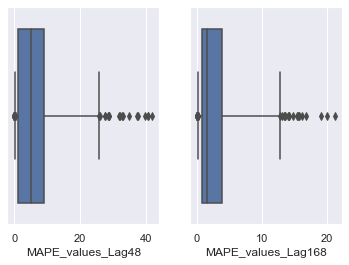

In [33]:
#The comparison of lag48 and lag168 naive approaches in part a
sns.set(font='sans-serif', font_scale=1)
y,ax = plt.subplots(1,2)
sns.boxplot( x= "MAPE_values_Lag48", data=testdf,whis=[5, 95] , ax=ax[0]);
sns.boxplot( x= "MAPE_values_Lag168",data=testdf,whis=[5, 95] , ax=ax[1]);

1) The middle quartile line (representing median) seems smaller in lag168 than in lag48. We want MAPE values to be as close to 0 as possible. 

2) The inter-quartile range in lag48 is wider than that of lag 168. This implies that lag 168 values have smaller variance than lag48. We can also observe that from 95th percentile of both plots (lag48 is around 25 while lag 168 is around 12).   **As a result, MAPE 168 probably has a smaller mean and variance. It implies that  lag168 mape values fall in a narrower range.**

3) Finally, the outliers are observed in both boxplots. These are the values that are not in the range [0.05 , 0.95] of the mean value. 

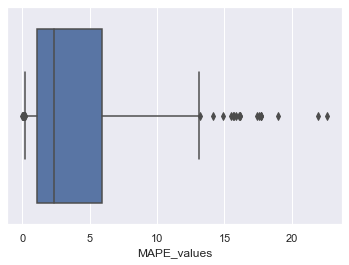

In [34]:
#The boxplot of MAPE values part b
sns.set(font='sans-serif', font_scale=1)
y2,ax2 = plt.subplots(1,1)
sns.boxplot( x= 'MAPE_values', data=testlong,whis=[5, 95] , ax=ax2);

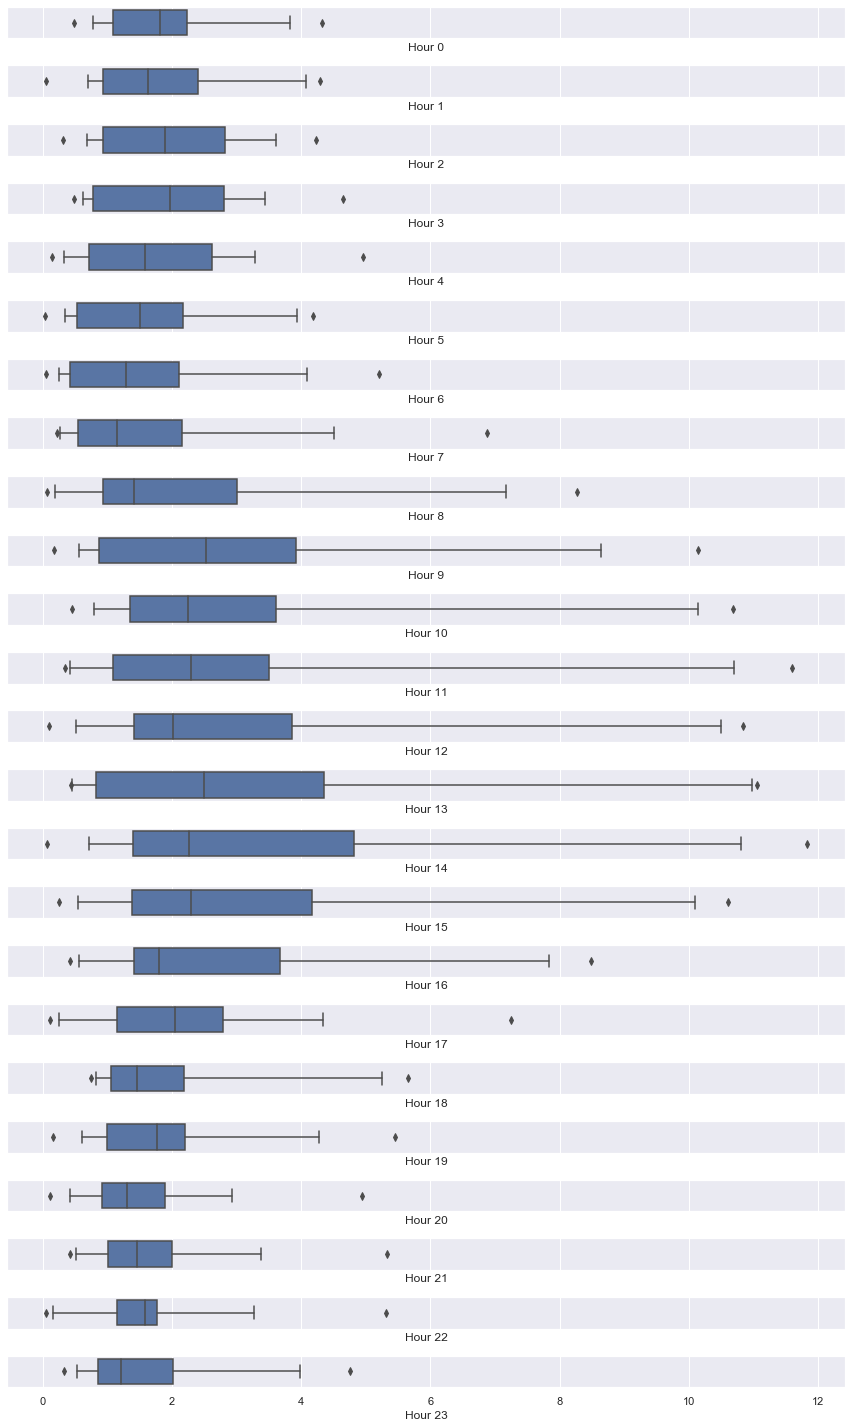

In [35]:
# The boxplot of each hours' MAPE values in part d
# We can draw the boxplots for each individual hour for part c.

sns.set(font='sans-serif', font_scale=1)
figure, axes = plt.subplots(24,1, figsize = (12,20), sharex = True)
for col in range(24):
    sns.boxplot( x= 'Hour '+str(col), data=lasso_MAPE_values_df,whis=[5, 95],  orient='h' , ax=axes[col])
plt.tight_layout()

1) Median (middle quartile line) seems to be closest to zero in Hour 23. These values most probably have the smallest mean.

2) The narrowest interquartile range [0.25 0.75] is observed in hour 22. These mape values most probably have the smallest variance.

3) Outliers exist in hourly lasso regression mape values.

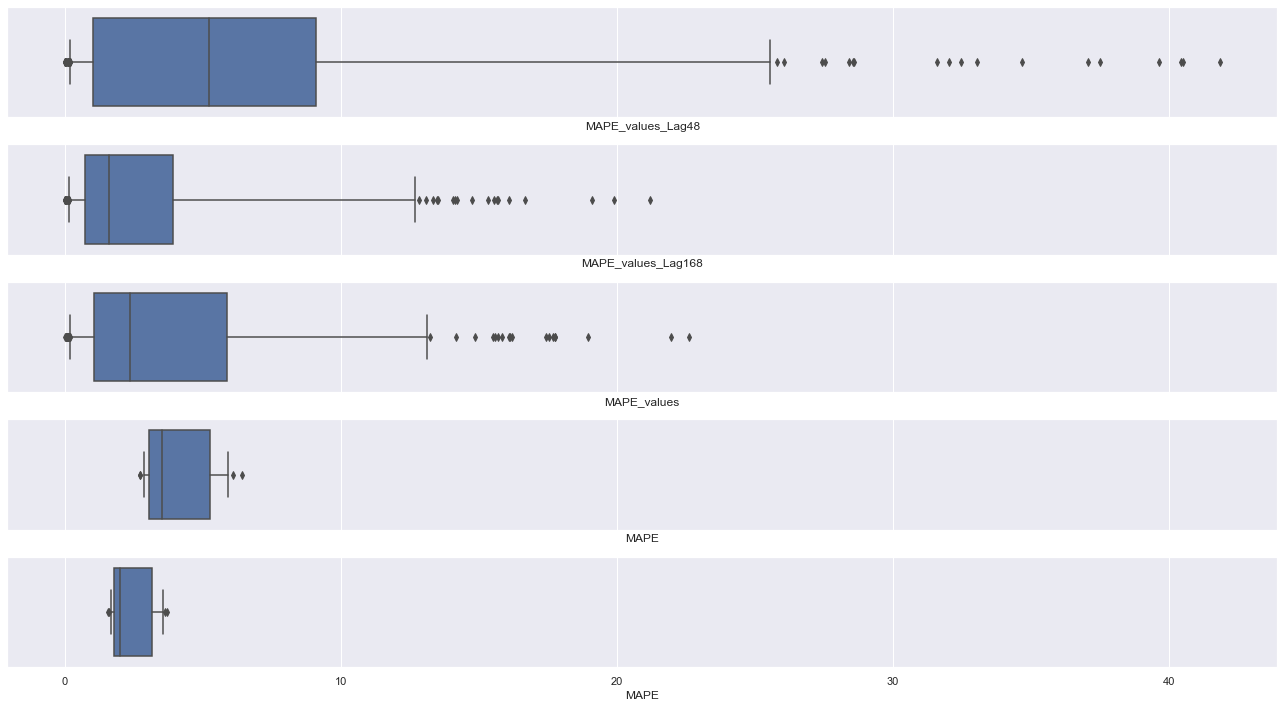

In [36]:
#Lets draw all MAPE values in each models. (for part c and d average MAPE values are used (24x1).)

sns.set(font='sans-serif', font_scale=1)
figure, ax = plt.subplots(5,1, figsize = (18,10), sharex = True)

sns.boxplot( x= "MAPE_values_Lag48", data=testdf,whis=[5, 95] , ax=ax[0]);     #Lag 48 Naive Approach

sns.boxplot( x= "MAPE_values_Lag168",data=testdf,whis=[5, 95] , ax=ax[1]);     #Lag 168 Naive Approach

sns.boxplot( x= 'MAPE_values', data=testlong,whis=[5, 95] , ax=ax[2]);         #Linear Regression

sns.boxplot( x= 'MAPE', data=MAPE_seasonaldf,whis=[5, 95] , ax=ax[3]);         #Seasonality (Mean of hours)

sns.boxplot( x= 'MAPE', data=MAPE_lassodf,whis=[5, 95] , ax=ax[4]);           #Lasso (Mean of hours)

plt.tight_layout()

o Above boxplots represent Lag 48 Naive Approach,Lag 168 Naive Approach,Linear Regression,Seasonality (Mean of hours) and Lasso (Mean of hours), respectively.

1) As we have previously concluded, the model with the smallest mean was Lasso Regression in part d. Nevertheless, the smallest median value belongs to lag168 Naive Approach in part a. It means that even though average of MAPE values are smaller in lasso regression model, the median value is larger.

2) Moreover, the smallest interquartile range and whis range [0.05 0.95] belongs to Lasso Regression. Besides, the lasso regression have fewer number of outliers. Let's determine variance of these MAPE values.

In [37]:
print("Variance of Lag 48 Naive Approach is " + str(testdf["MAPE_values_Lag48"].var().round(4)))
print("Variance of Lag 168 Naive Approach is " + str(testdf["MAPE_values_Lag168"].var().round(4)))
print("Variance of Linear Regression is " + str(testlong["MAPE_values"].var().round(4)))
print("Variance of Seasonality (Mean of hours) is " + str(MAPE_seasonaldf["MAPE"].var().round(4)))
print("Variance of Lasso Regression is (Mean of hours) is " + str(MAPE_lassodf["MAPE"].var().round(4)))

Variance of Lag 48 Naive Approach is 68.8371
Variance of Lag 168 Naive Approach is 16.7878
Variance of Linear Regression is 18.2229
Variance of Seasonality (Mean of hours) is 1.5564
Variance of Lasso Regression is (Mean of hours) is 0.5735


As expected, Lasso regression has the smallest variance. As a result, even though Lasso Regression model's median value is a bit larger than lag_168 naive approach, it has smaller mean and variance. Variance of each hour is approximately 24*0.5735, which is also smaller than any other models. 